In [78]:
import pandas as pd
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import os
import missingno as mp
import matplotlib.pyplot as plt

In [3]:
s = os.environ['share_str']
e = create_engine(s)

In [52]:
sql = """with dates_table as (
  select client_id, 
         first_value(created_at) over (partition by client_id order by created_at asc) first_txn,
         date_trunc('month', first_txn) first_txn_month,
         date_trunc('month', created_at) active_month
  from payclip.star.transactions t
  left join payclip.star.transaction_detail td
  on t.receipt_no = td.receipt_no
  where status_code = 1
),

cohorts as (
  select distinct client_id,
         first_txn_month,
         active_month
  from dates_table
  where active_month <= dateadd('month', 3, first_txn_month) -- use only first three months
  and first_txn >= '2017-07-01 00:00:00'
  and first_txn_month <= '2018-08-01 00:00:00' -- avoid cohorts with less than three months since activation
)

select *
from cohorts
"""

df = pd.read_sql(sql, e)
df.head()

,client_id,first_txn_month,active_month
0,879a22f69c1e56748615f86895770a3daf4391e7375320...,2018-03-01,2018-04-01
1,12ca5b2fb4ffbf6b38b8a67ca192fb85b8e07e0837b1f8...,2017-09-01,2017-12-01
2,476b591ecf30b0c9c70e9a5ba55935f03a46f964c5ca69...,2018-05-01,2018-08-01
3,3661f54e78f30bd3fa3aaa15710e82e47fd6c4d19fed3b...,2018-02-01,2018-02-01
4,5f39280a2ce1bfaa3f48fd4685d4b9c166c98a24b6c576...,2018-05-01,2018-08-01


In [53]:
df['active'] = 1

## Build one missingness plot as an example. 
### The following chart is composed by very thin rows each of which represents a customer. Each column represents a month. When a cell is black, the given customer was active in that particular month and inactive when white.

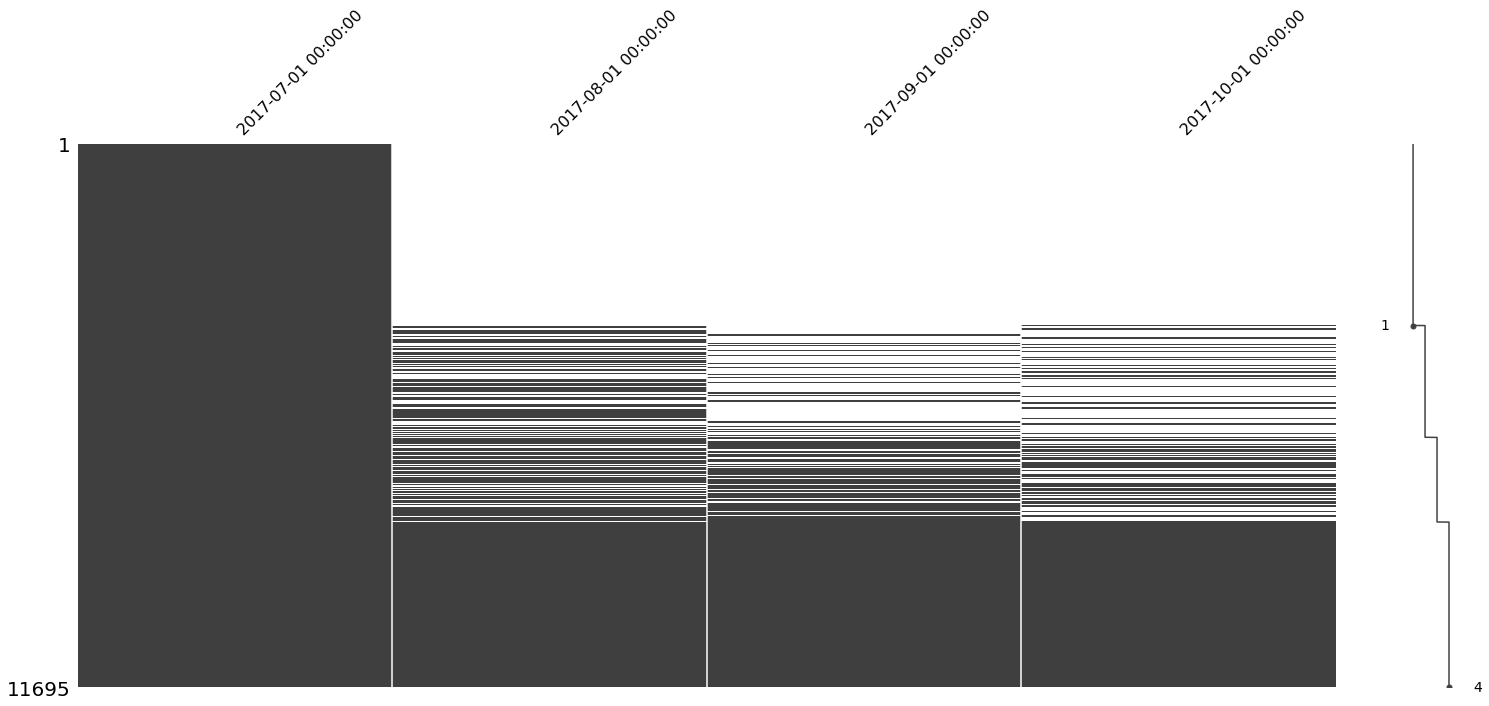

In [54]:
cohorts = df.first_txn_month.sort_values().unique()

melted = df[df.first_txn_month == cohorts[0]].pivot_table(columns = 'active_month', index = ['client_id', 'first_txn_month'], values = 'active')
melted['periods'] = melted.sum(axis = 1)
melted = melted.sort_values(by = 'periods', ascending = True).reset_index().drop(['client_id', 'first_txn_month', 'periods'], axis = 1)
mp.matrix(melted)

define function to calculate the latter

In [49]:
def print_missingness_plot(df, cohort):
    melted = df[df.first_txn_month == cohort].pivot_table(columns = 'active_month', index = ['client_id', 'first_txn_month'], values = 'active')
    melted['periods'] = melted.sum(axis = 1)
    melted = melted.sort_values(by = 'periods', ascending = True).reset_index().drop(['client_id', 'first_txn_month', 'periods'], axis = 1)
    mp.matrix(melted)

#### Let's have a look at customer activity within their fisrt five months to see if churn rate seems to be increasing/decreasing. Take only cohorts that have had at least 4 months of activity.
#### The goal is to show that most of Clip's churn is in the first few months

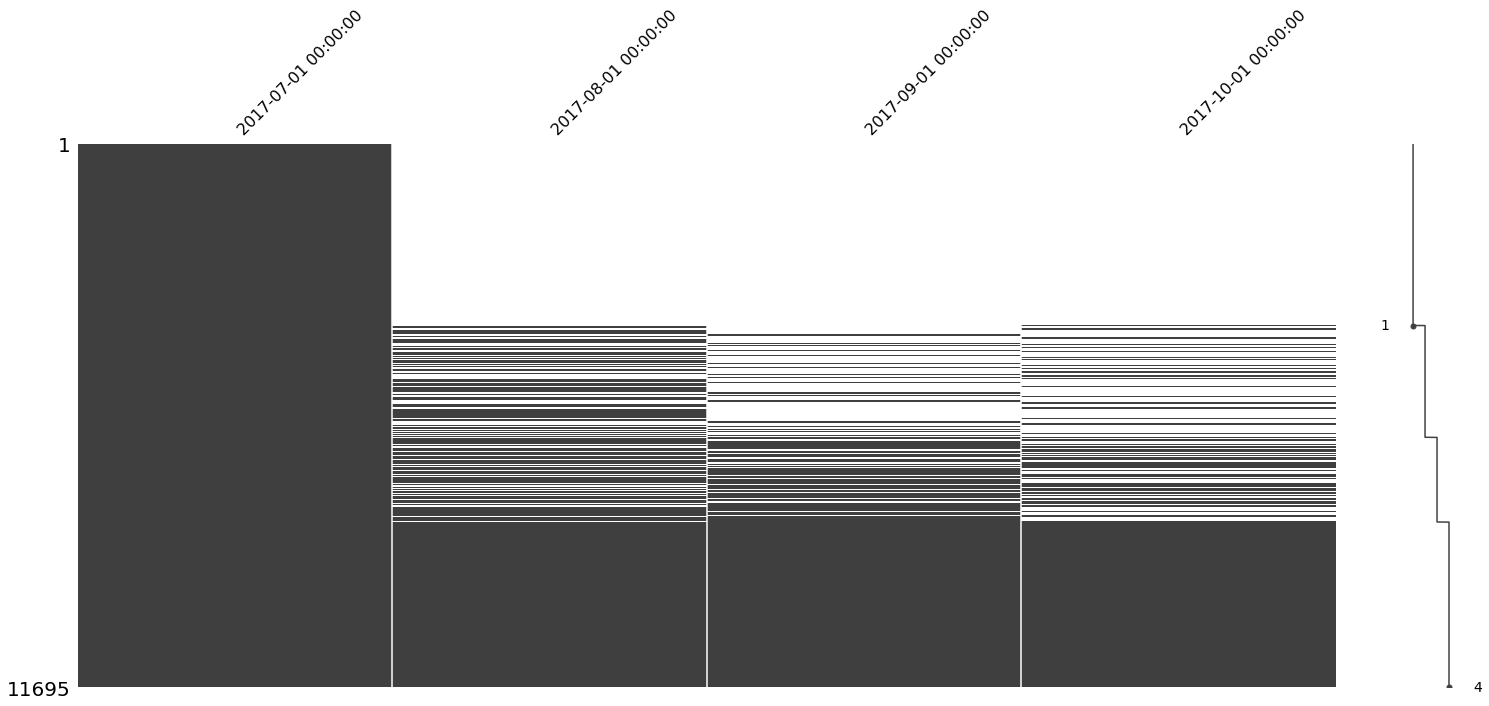

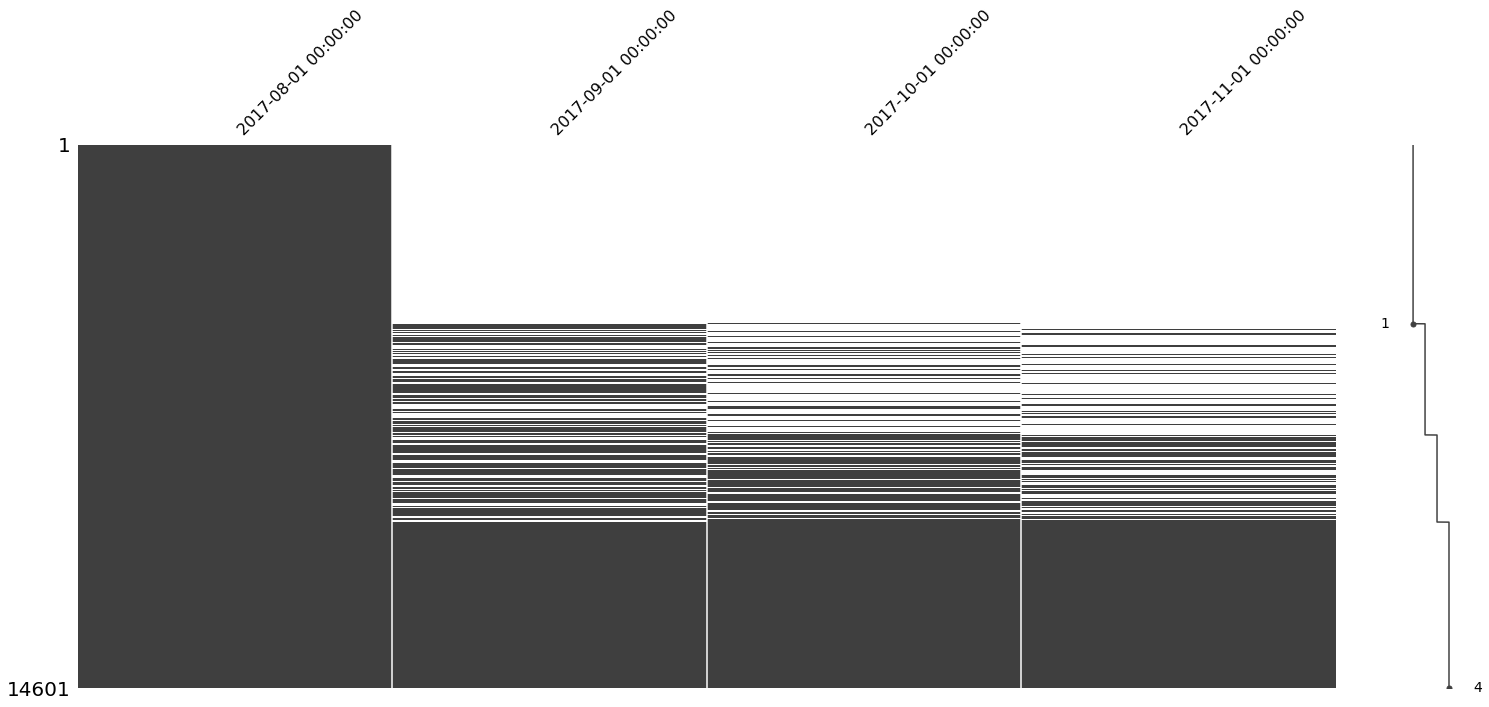

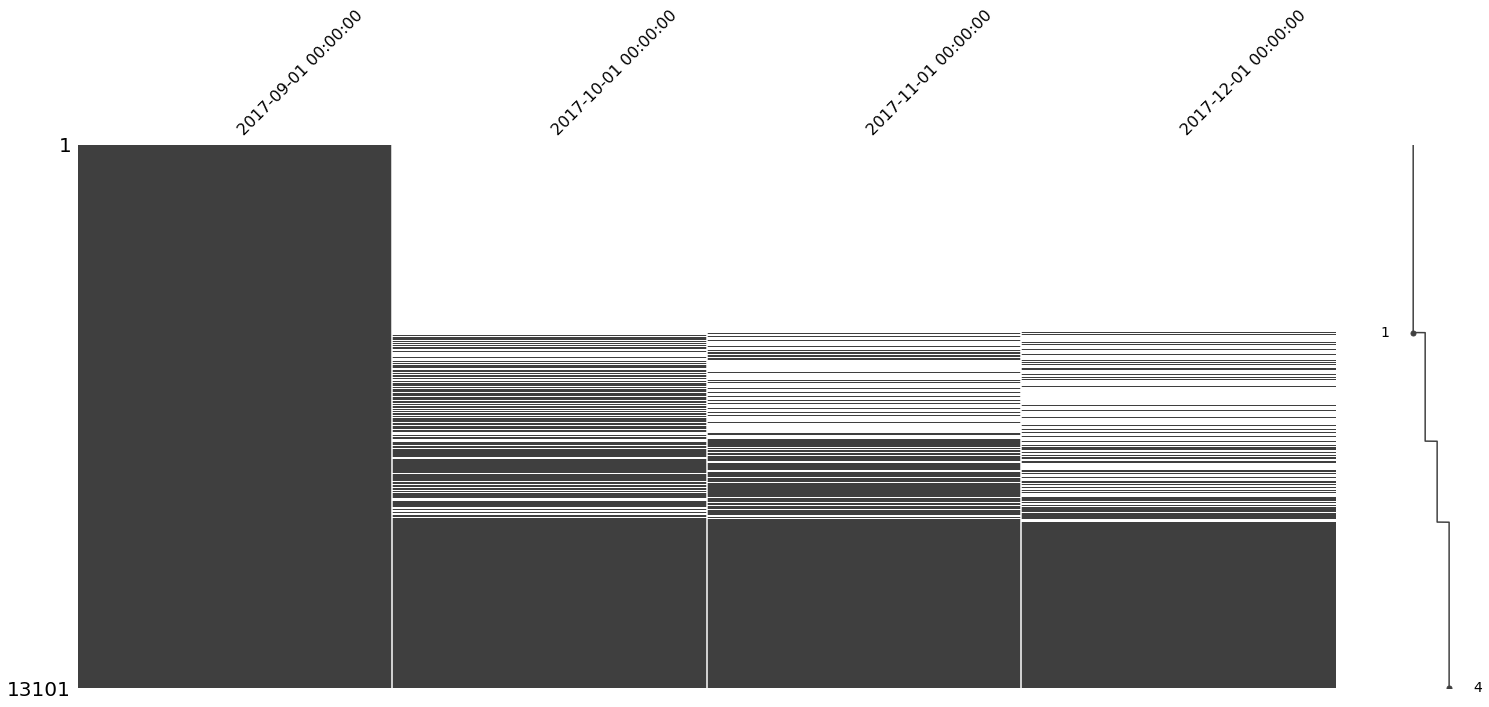

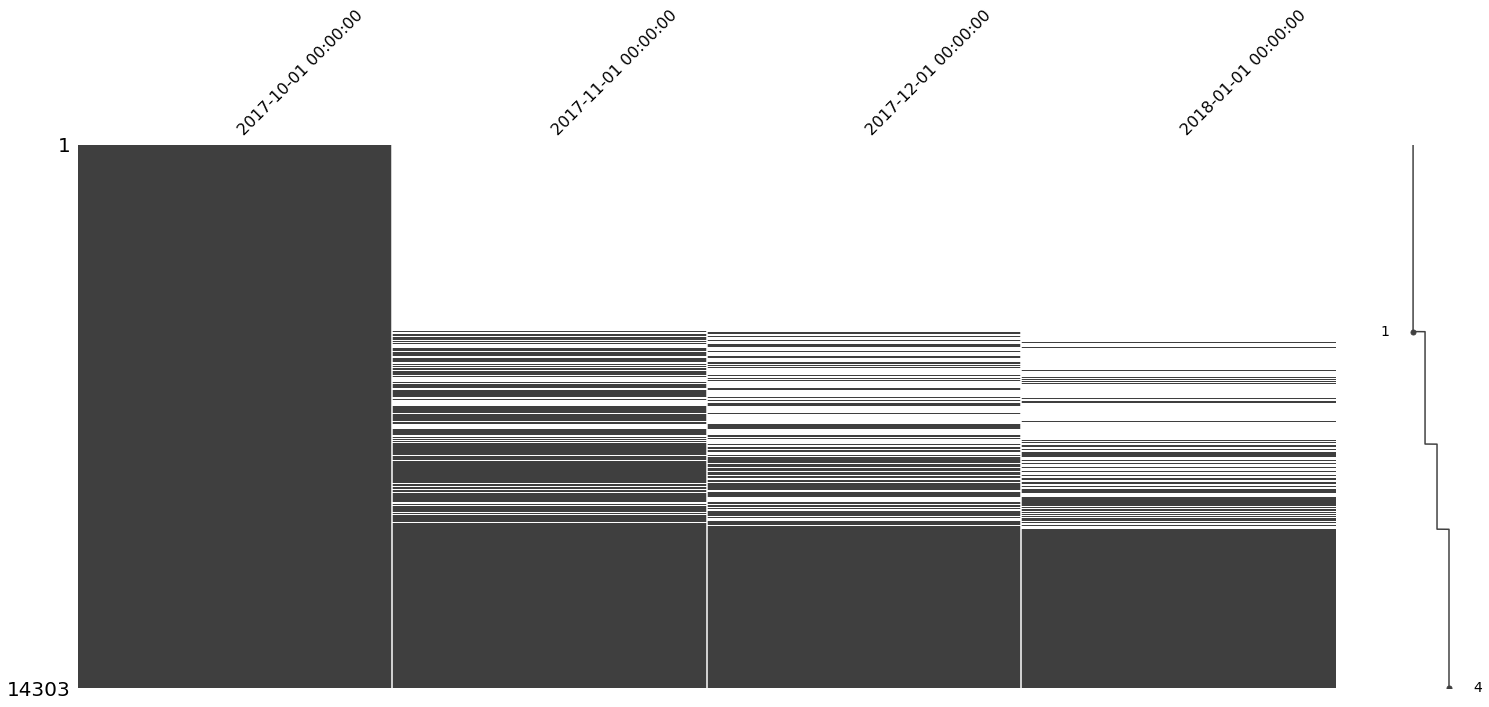

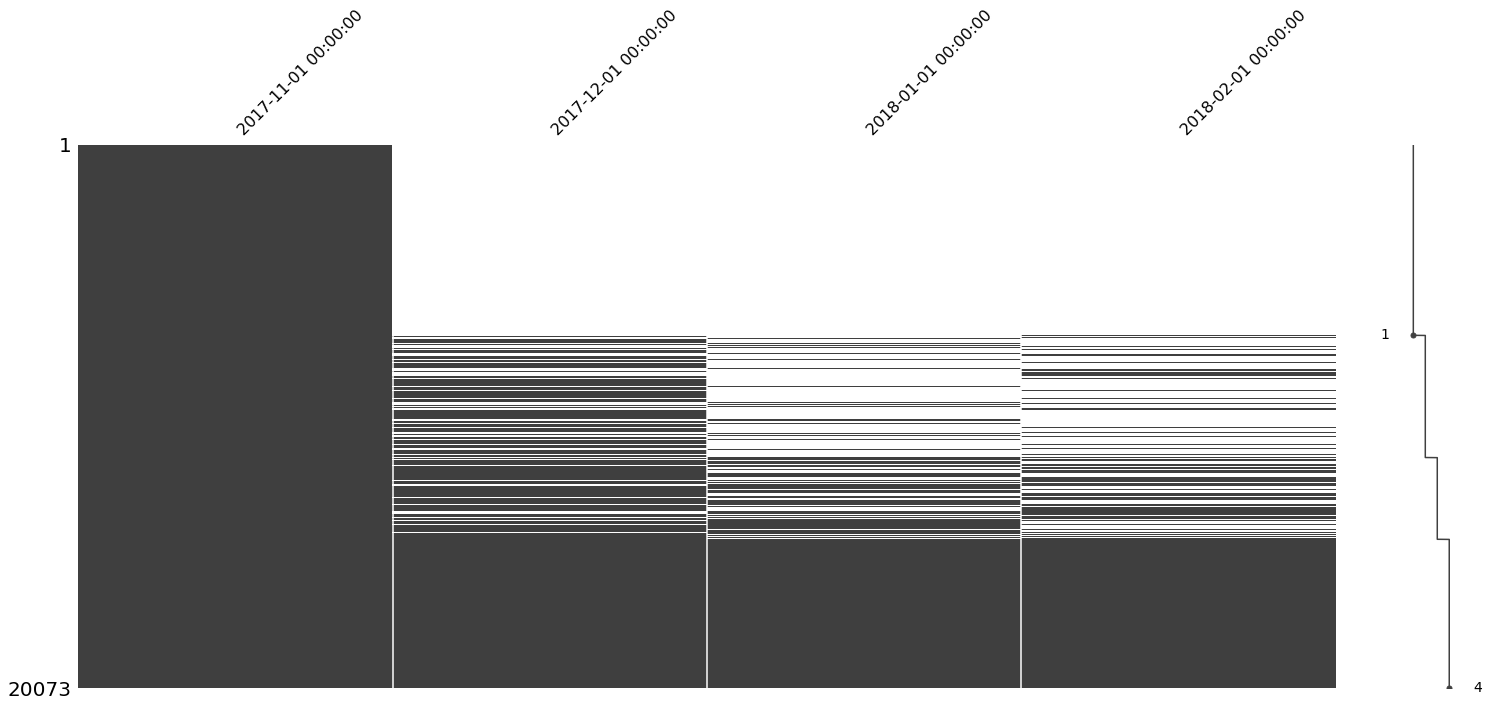

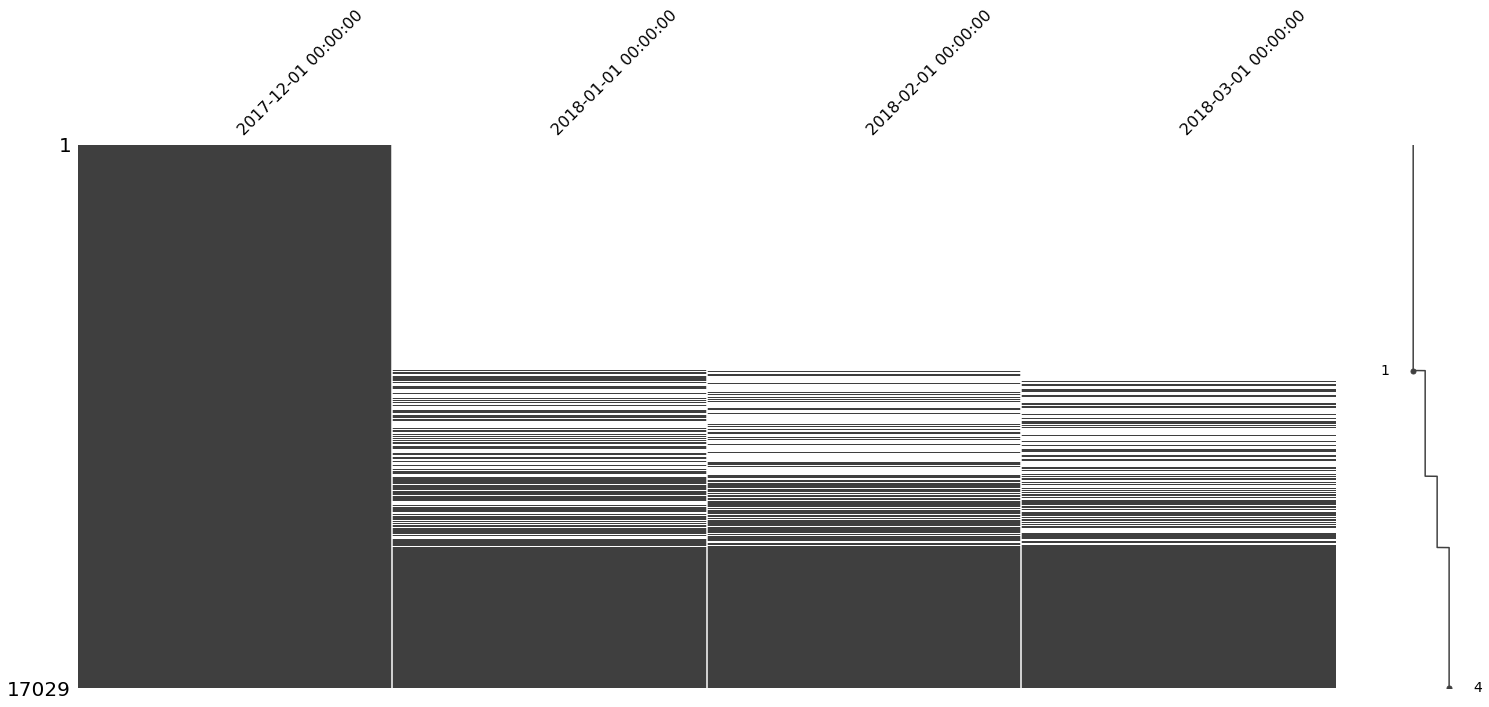

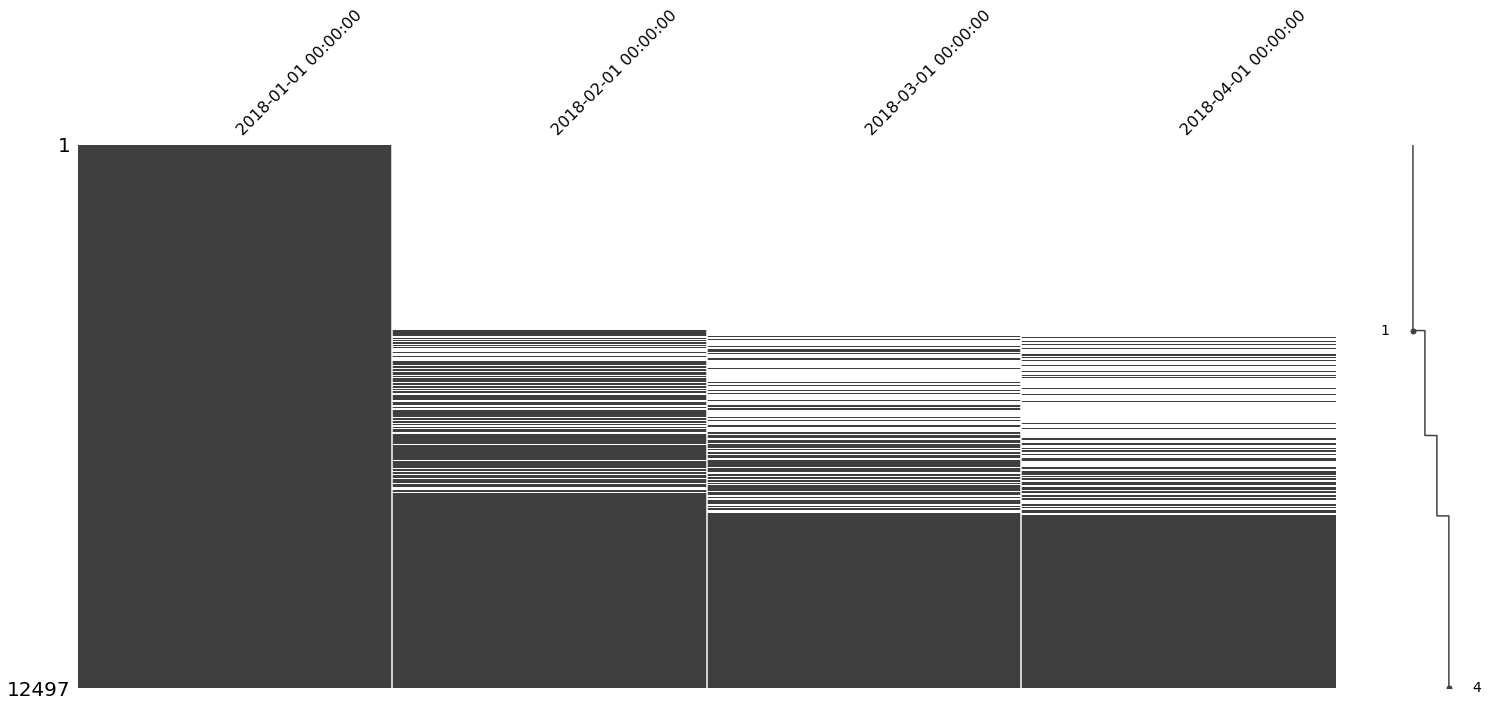

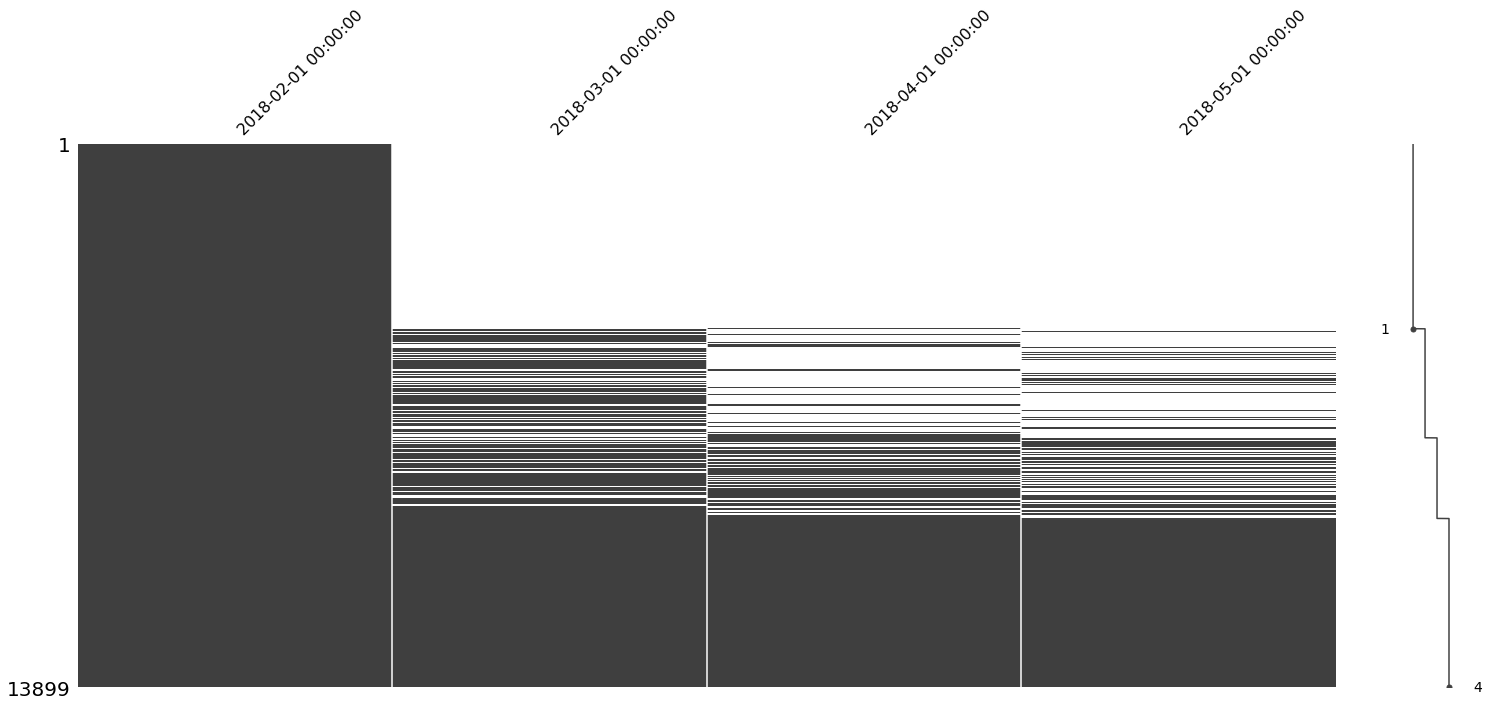

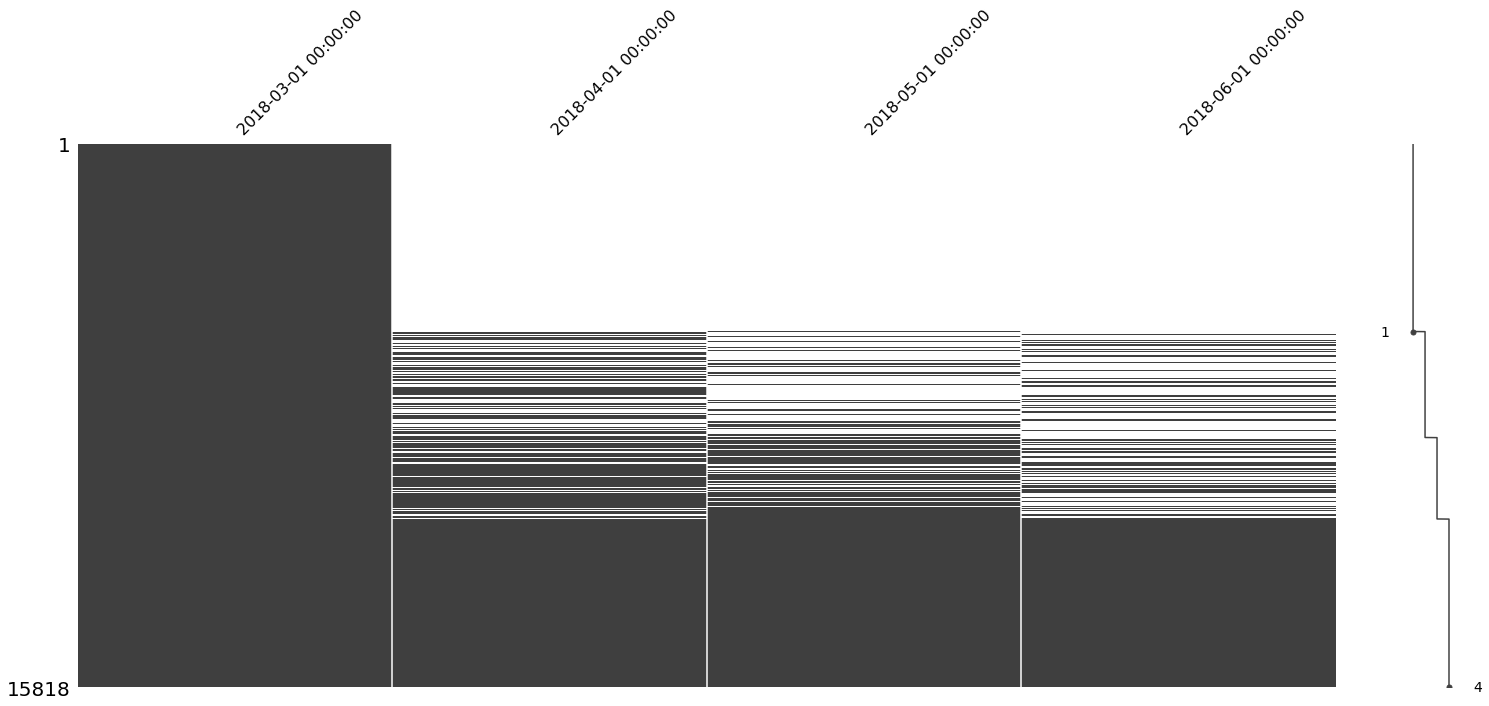

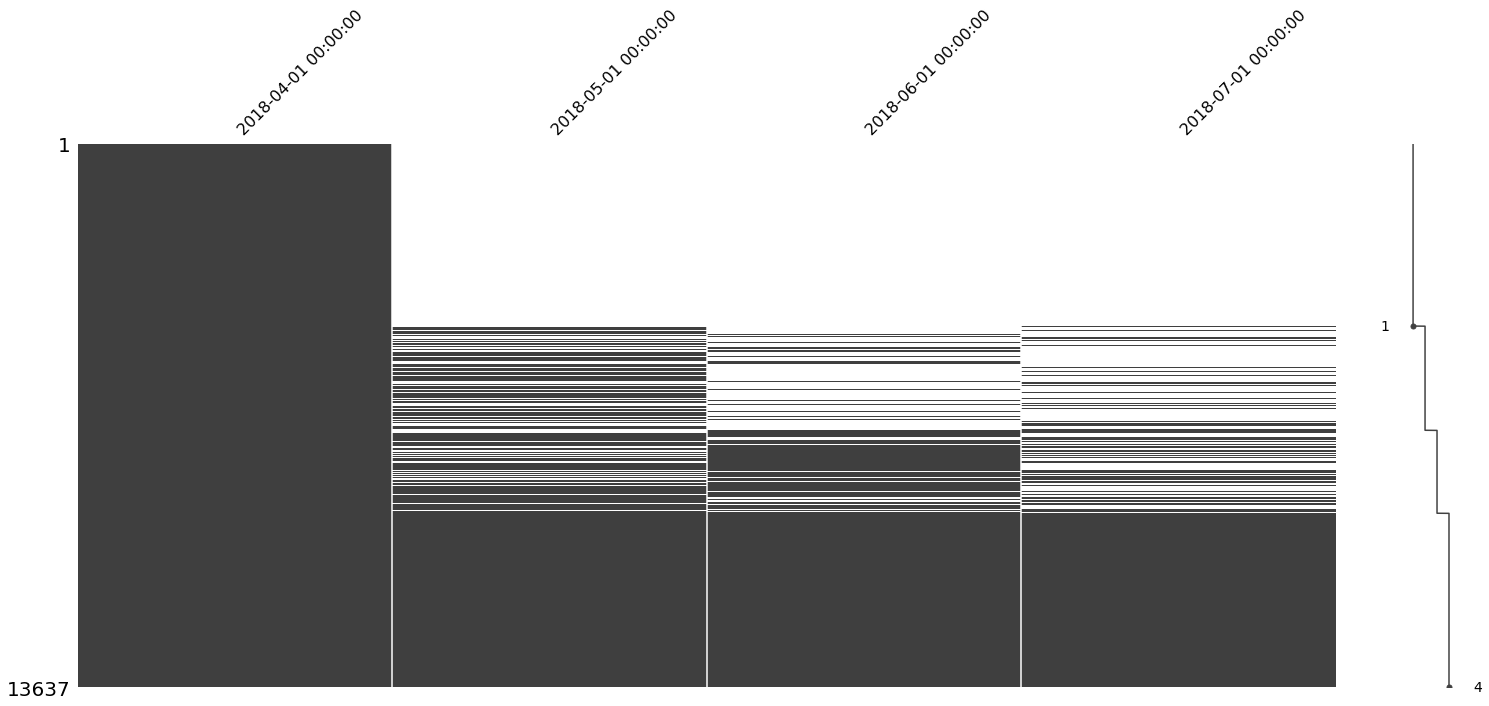

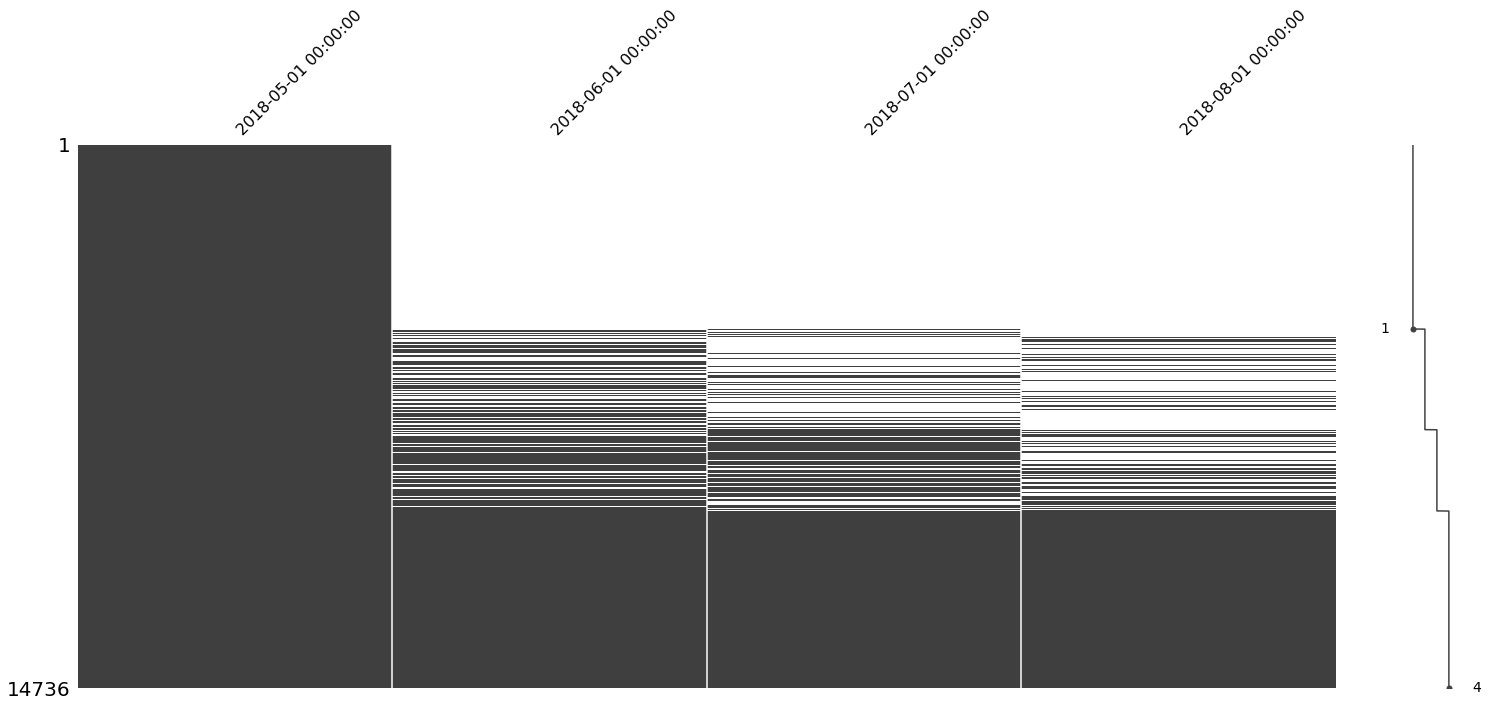

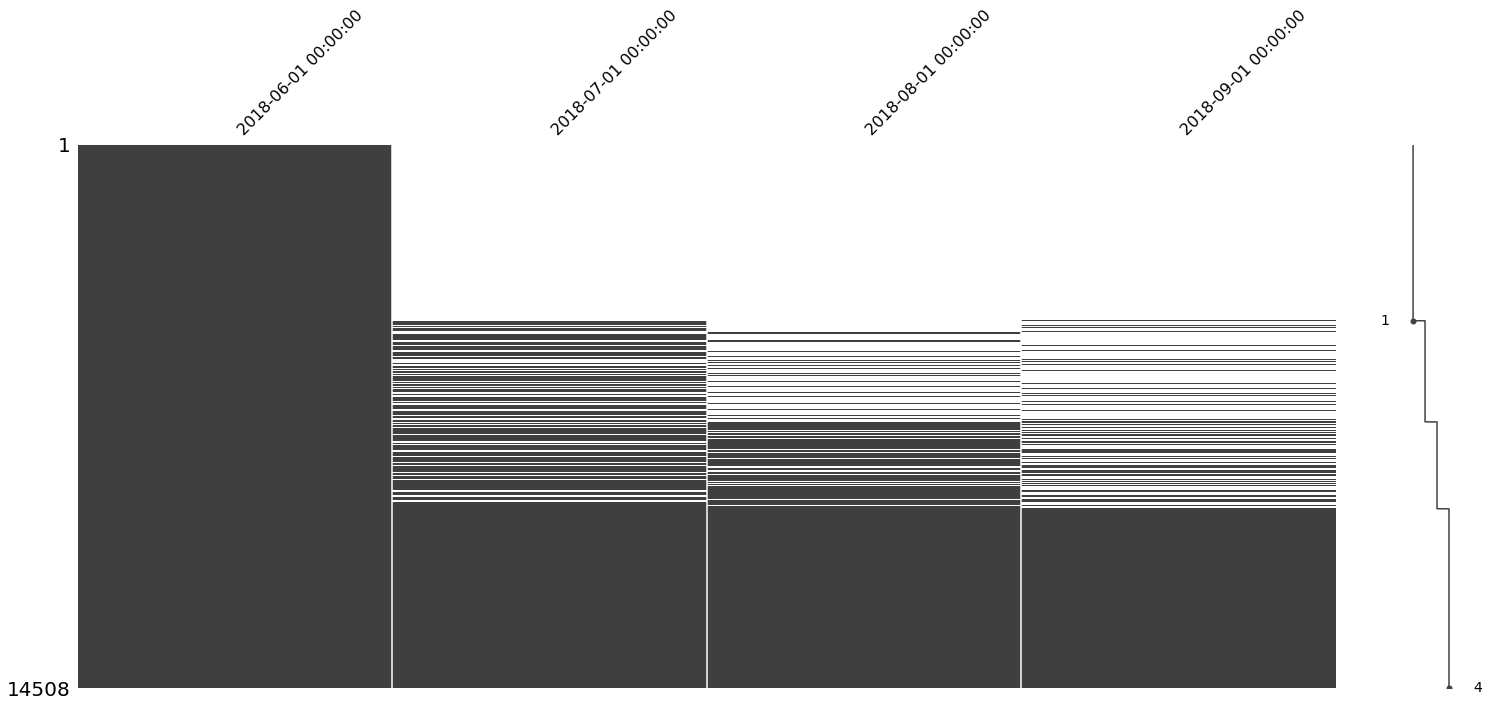

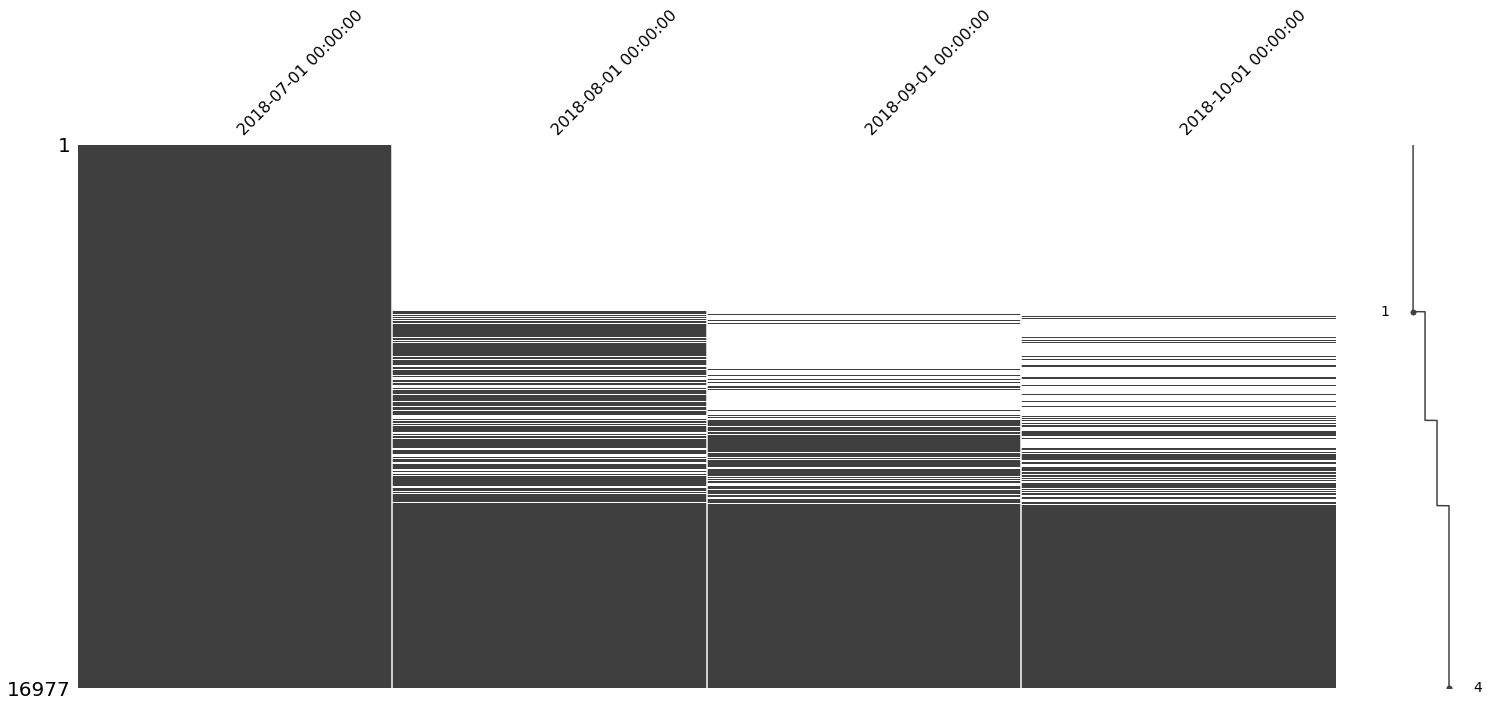

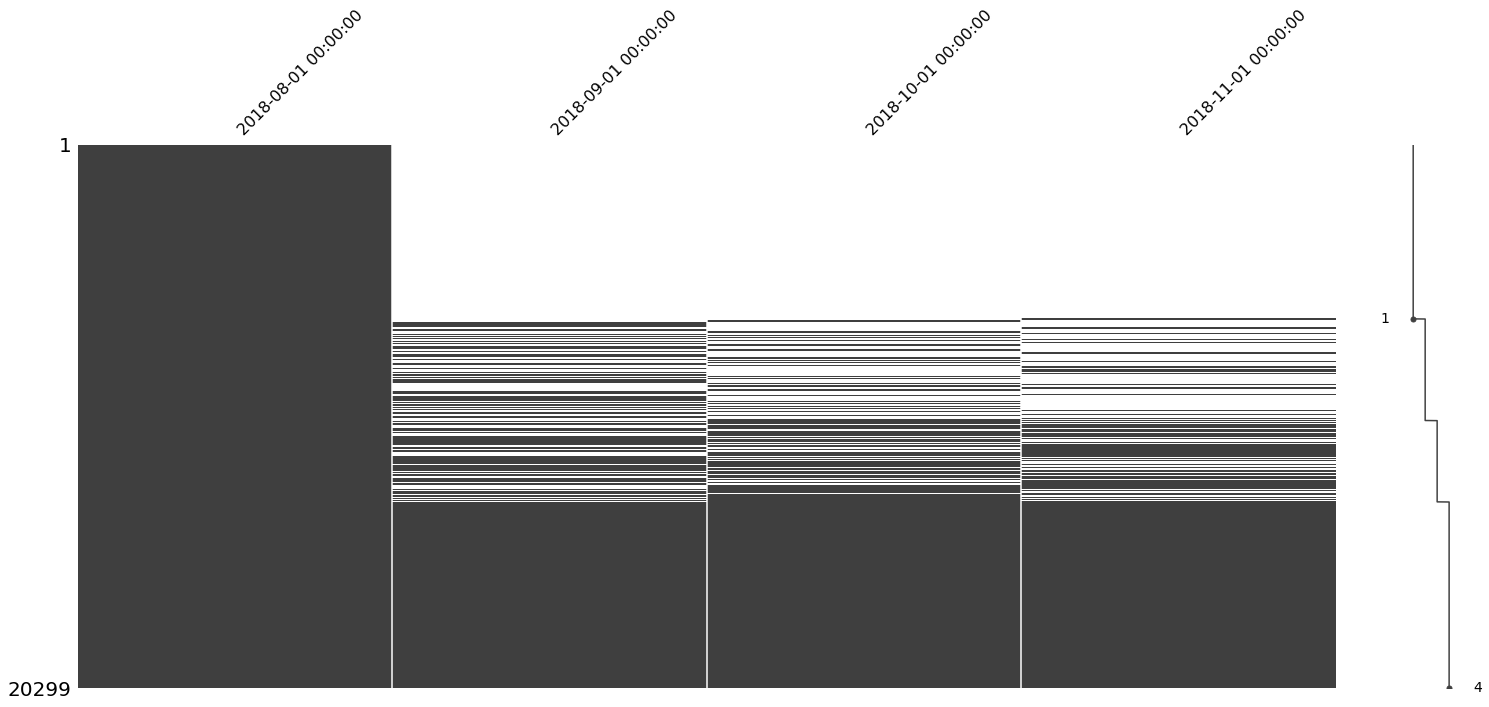

In [55]:
[print_missingness_plot(df, cohort) for cohort in cohorts];

## Looks like churn rate within the first few months didn't change a lot among cohorts. Even though this charts only consider cohorts of customers that activated between July 2017 and September 2018, this trend seems to be real. It is clear that around 40% of customers churn within the first month and do not come back. Monthly churn in consecutive periods is harder to visualize but it is clear that the highest chrun rate comes from the first month and about 60-70% of customers are not active for 4 consecutive months.

# Now I would like to take a look at customers who leave within the first month! How does the amount, industry, region and frequency distributions look like compared to 'usual' customers?
# Have churned customers transacted only once or a few times? 

In [61]:
q = """
with churn as (
select client_id, 
       first_value(created_at) over (partition by client_id order by created_at asc) first_txn,
       first_value(created_at) over (partition by client_id order by created_at desc) last_txn,
       amount, 
       onboarding_state,
       industry,
       case when datediff('month', first_txn, last_txn) = 0 then 'churned' else 'not churned'end  as churn
from payclip.star.full_table 
where status_code = 1)

select *
from churn 
where first_txn >= '2017-07-01 00:00:00'
"""

In [67]:
g = pd.read_sql(q, e, chunksize = 1000000)

In [68]:
i = 1
data = []

for chunk in g:
    data.append(chunk)
    print(i)
    i = i + 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [72]:
df2 = pd.concat(data)
df2.head()

,client_id,first_txn,last_txn,amount,onboarding_state,industry,churn
0,765d04f8431445848bc46412e6b0a9e87c9442efca7e8e...,2017-07-16 18:43:07,2018-12-27 15:54:37,50.0,Ciudad de México,Alimentos y bebidas,not churned
1,bf80627ac2a009dc22ab7122f3a8ff47c5a9bb18f5196f...,2017-11-27 12:52:55,2018-12-30 20:47:21,120.0,México,Entrentenimiento y experiencias,not churned
2,4663605e478719fc257bb9dbb27d6f852064d1d9407744...,2017-09-09 13:42:08,2018-12-15 17:44:16,300.0,San Luis Potosí,Ropa y accesorios,not churned
3,640155456a108fcc41a4e0c89e9c4fab38f63439e916f8...,2017-09-12 17:20:46,2018-12-30 14:06:57,300.0,Sonora,Servicios Generales,not churned
4,c42028df1d6685405bcc7955d4e2fd621539e6f14dc4c5...,2018-08-17 15:14:07,2018-12-23 15:21:08,1500.0,Puebla,Servicios profesionales,not churned


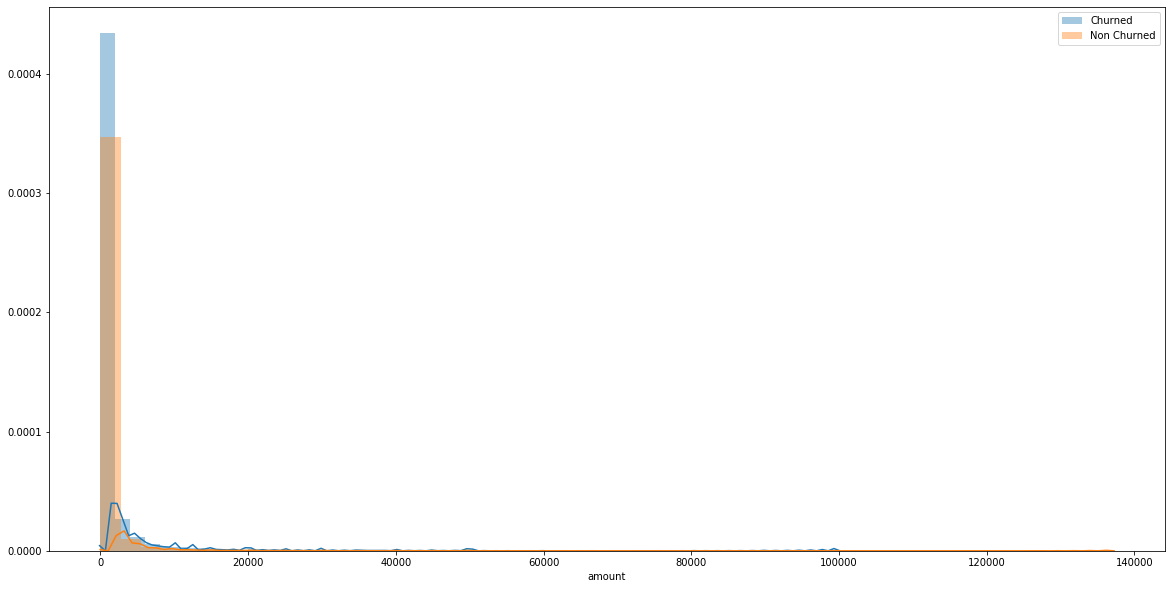

In [81]:
plt.figure(figsize = (20, 10))
sns.distplot(df2[df2.churn == 'churned'].amount, label = 'Churned')
sns.distplot(df2[df2.churn == 'not churned'].amount, label = 'Non Churned')

plt.legend()

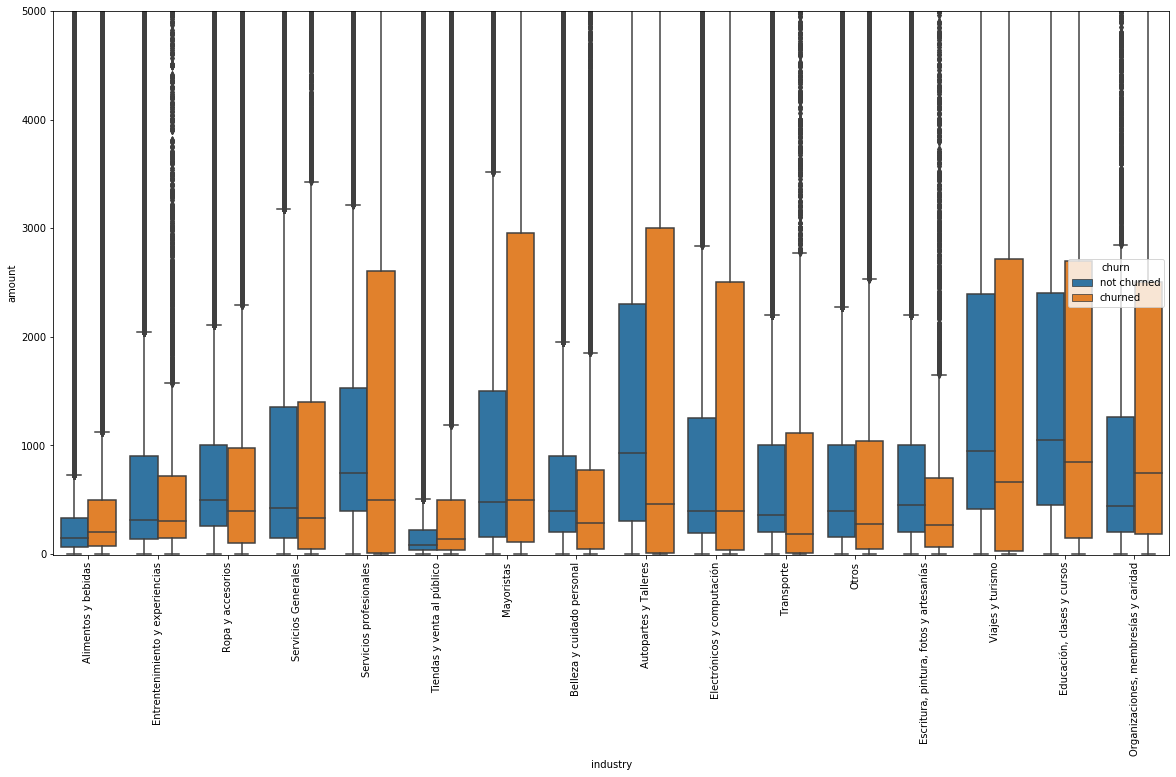

In [95]:
plt.figure(figsize = (20, 10))
p = sns.boxplot(x = 'industry', y = 'amount', hue = 'churn', data = df2)

p.set_ylim(-5, 5000)
p.set_xticklabels(p.get_xticklabels(), rotation = 90);

Do not quite see any trend that may help us difference customers who are about to churn

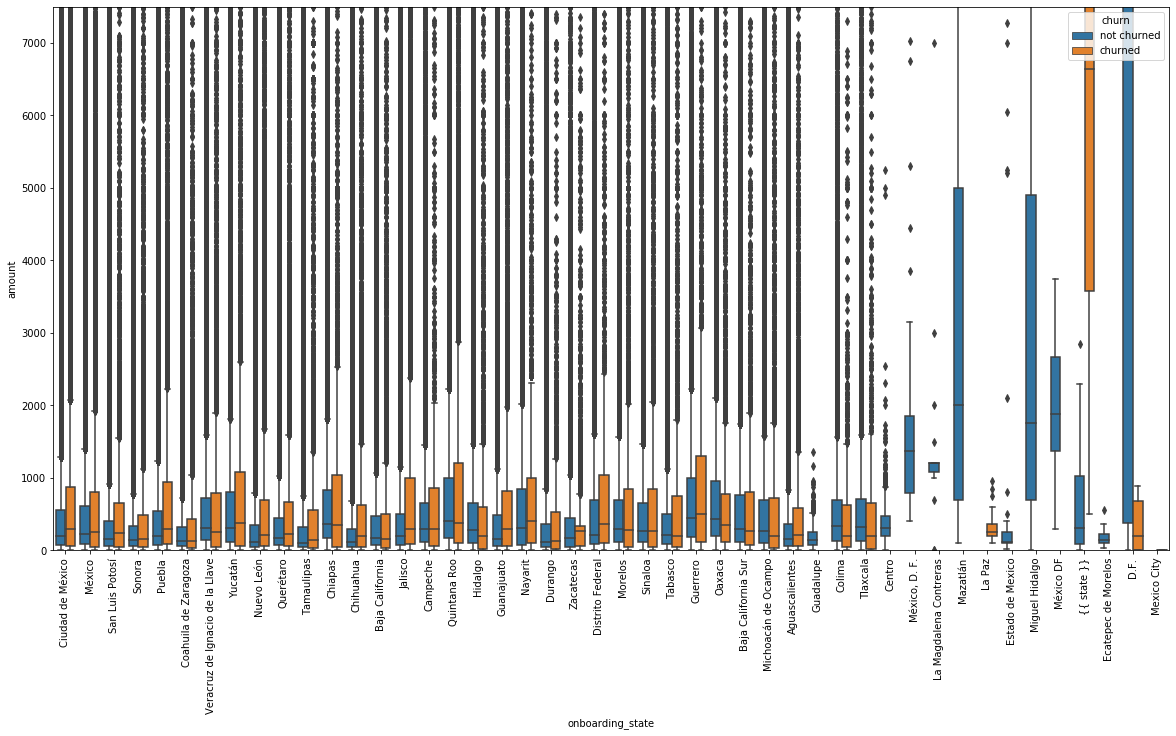

In [98]:
plt.figure(figsize = (20, 10))
p = sns.boxplot(x = 'onboarding_state', y = 'amount', hue = 'churn', data = df2)

p.set_ylim(0, 7500)
p.set_xticklabels(p.get_xticklabels(), rotation = 90);

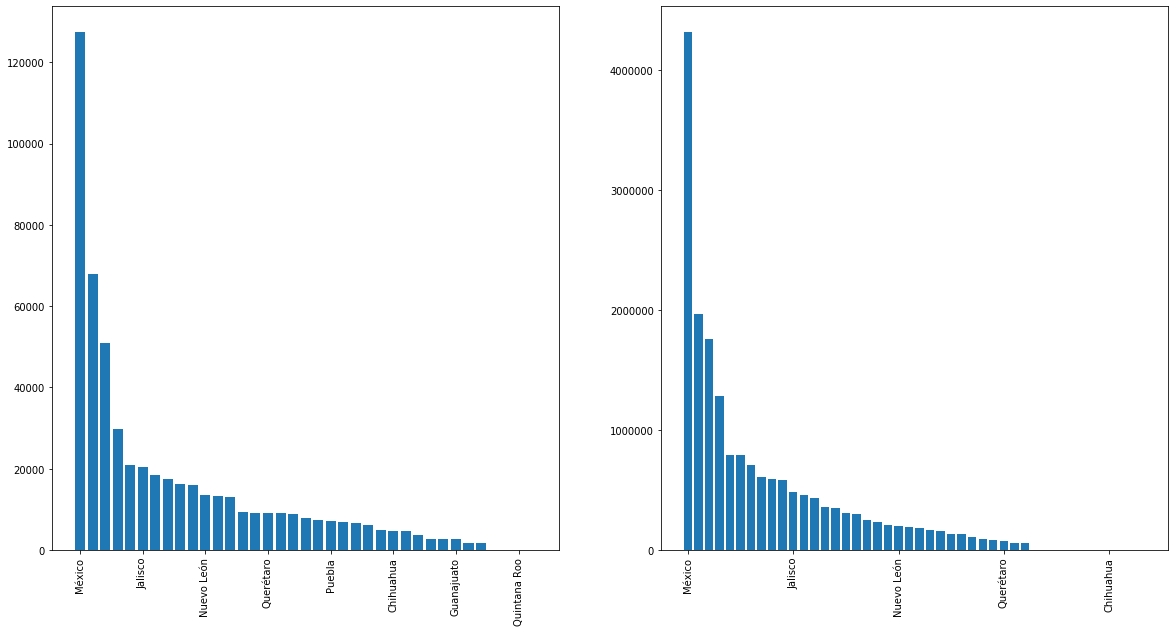

In [122]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
h1 = df2[df2.churn == 'churned'].onboarding_state.value_counts()
n1 = len(h1.index)
x1 = np.arange(len(h1.index))
labels1 = h1.index[x1]


h2 = df2[df2.churn == 'not churned'].onboarding_state.value_counts()
n2 = len(h2.index)
x2 = np.arange(len(h2.index))
labels2 = h2.index[x2]

axes[0].bar(x1, h1)
axes[0].set_xticklabels(labels1, rotation = 90);


axes[1].bar(x2, h2)
axes[1].set_xticklabels(labels2, rotation = 90);

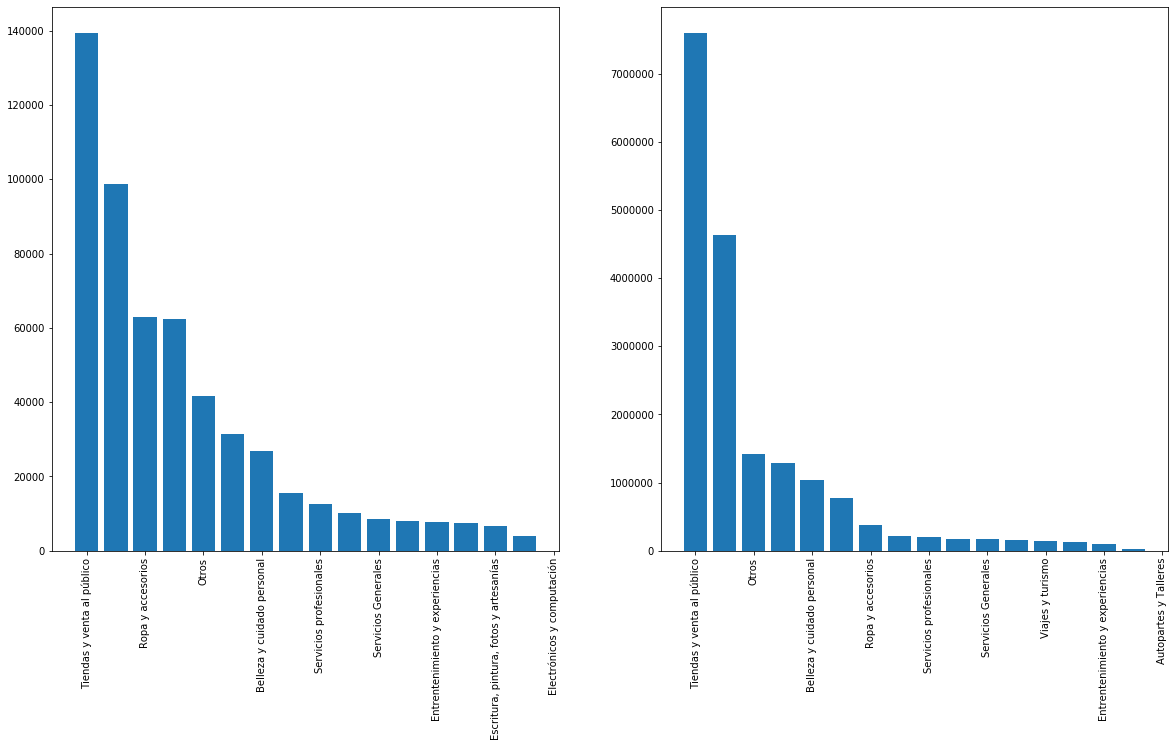

In [124]:
fig, axes = plt.subplots(1, 2, figsize = (20, 10))
h1 = df2[df2.churn == 'churned'].industry.value_counts()
n1 = len(h1.index)
x1 = np.arange(len(h1.index))
labels1 = h1.index[x1]


h2 = df2[df2.churn == 'not churned'].industry.value_counts()
n2 = len(h2.index)
x2 = np.arange(len(h2.index))
labels2 = h2.index[x2]

axes[0].bar(x1, h1)
axes[0].set_xticklabels(labels1, rotation = 90);


axes[1].bar(x2, h2)
axes[1].set_xticklabels(labels2, rotation = 90);